In [20]:
%matplotlib inline
import numpy as np;from matplotlib import pyplot as plt;import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

### 3.1 贝叶斯景象图

#### 一. 包含2个未知元素的贝叶斯推断问题

1. 对于一个含有N个未知元素的贝叶斯推断问题, 我们隐式的围棋先验分布创建了一个N维空间.    
 这个N维曲面的形状由N个元素的先验分布函数决定. 每一个确定下来的N个元素值组成的向量, 都是N维曲面上的一个点
 
2. 对于2个未知元素$p_1,p_2$的贝叶斯推断问题. 假设其先验分布都是[0,5]均匀分布. 则其共同组成的先验分布形成边长为5的正方形, 其联合概率值$(p_1=x_1,p_2=x_2)$形成了该正方形上的一个平面

3. 假设两个未知元素$p_1,p_2$, 先验分布分别为$Exp(3)和Exp(10)$(因此$p_1$均值为在$\frac{1}{3}$,$p_2$均值为在$\frac{1}{10}$). 则其先验形成的概率面是一个从(0,0)点想正值方向流淌的瀑布  
<img src='img/mcmc1.png' width='80%' height='80%'>

4. 上图描述了先验分布的概率图, 当得到观测样本以后, 先验概率面的形状会在某些局部区域拉伸或挤压, 以表明参数的真实值集中在哪里. 更多的数据对概率面产生更多大的挤压效果, 形成后验分布上的山峰


#### 二. 使用MCMC探索景象图
1. 当位置元素的个数很多时, 先验分布空间的维度很大. 遍历一个N维空间的复杂度, 随着N呈指数级增长. 也就是在计算后验概率时, 分母的归一化积分项$p(x)=\int { p(x|{ \theta  }^{ 1 },{ \theta  }^{ 2 }..{ \theta  }^{ n }) } *p({ \theta  }^{ 1 },{ \theta  }^{ 2 }..{ \theta  }^{ n })d{ \theta  }^{ 1 }d{ \theta  }^{ 2 }..d{ \theta  }^{ n }$难以计算. 因此MCMC改用抽样的方式抽取满足后验概率帆布的样本点集合
2. MCMC步骤描述   
MCMC想象成不断重复的问一块石头: 你是不是来自于我要找的那座山? 并试图用上千个肯定答案的石头来重塑那座山. 这些返回序列里的'石头'就是样本, 累积起来称为'迹'
  1. 从当前位置开始, 尝试移动一个位置
  2. 根据新的位置, 是否符合观测数据和先验分布, 决定采纳或拒绝这次移动. 大量迭代之后, 返回所采纳的点

#### 三. MCMC采样
1. MCMC采样, 是一种根据随机变量的概率分布形式, 抽样出符合分布函数的样本集的方法
2. 由马尔科夫链得知, 每个条件转移矩阵P, 都对应一个特定的平稳分布 (平稳状态向量)${\pi}$. 且无论初始状态是什么, 多次条件转移后状态都会变成该平稳分布. 因此, 我们设想随机给出一个初始状态分布${\pi}_0$, 只要找到对应的条件转移矩阵, 迭代转移多次后, 就能形成最终平稳分布${\pi}$  
  1. 马尔科夫链的平稳细致条件 :  
    状态转移矩阵P和概率分布$π(x)$对于所有的i,j满足：$π(i)P(i,j)=π(j)P(j,i) $
  2. 但是我们不知道${\pi}$ 真正的条件转移矩阵P是什么, 于是  
      1. 若我们随即找到一个条件转移矩阵$Q$, 往往并不满足平稳细致条件, 即$π(i)Q(i,j)≠π(j)Q(j,i)$  
      2. 为使细致平稳条件成立,引入一个α(i,j),使上式可以取等号. 即 : $$π(i)Q(i,j)α(i,j)=π(j)Q(j,i)α(j,i)$$  
      3. 什么样的α(i,j)可以使等式成立呢？其实很简单，只要满足下两式即可$$α(i,j)=π(j)Q(j,i)\\α(j,i)=π(i)Q(i,j)$$这样真正的条件转移矩阵, 就有P(i,j)=Q(i,j)α(i,j), 其中Q(i,j)是随机选择的转移矩阵, α(i,j)是接受率.  
      4. 现在问题只剩α(i,j)如何得来? α(i,j)又叫接受率, 即有多大概率接受状态$i$(分布$i$)变成状态$j$(分布$j$).   
       M-H采样给出$α(i,j)=min\{\frac{\pi(j)Q(j,i)}{\pi(i)Q(i,j)},1\}$   , 往往选择$Q(j,i)=Q(i,j)$, 因此$α(i,j)=min\{\frac{\pi(j)}{\pi(i)},1\}$   
      5. 此时, 有了α(i,j)的值, 再给出一个阈值, 就可以判断是否接受此次状态更改(分布更改).设阈值u服从uniform(0,1), 每次从均匀分布中抽取一个值u当阈值. 若u< α(i,j) 则接受此次状态更改
3. MCMC过程 
  1. 为了对目标分布$\pi$抽样, 选择分布$Q$, 从Q中抽取随机变量的值为$x_*$, 作为最终样本列表中的候选值
  2. 随机抽取阈值u ~ $Uniform(0,1)$
  3. 计算u是否小于$min(\frac{\pi({x_*})}{\pi(x_{*-1})},1)$, 若结果为True, 则把$x_*$加入样本点的列表, 否则抛弃这次的$x_*$  
  
4. 下面程序, 用MCMC抽样正态分布N(3,4)的样本  
  1. 使用scipy.stats模块, 计算某个分布, 随机变量值=x的概率  
  2. 使用pymc模块, 生成服从某个分布的随机变量, 再通过value属性获取这个分布下随机变量的随机值

/devkit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


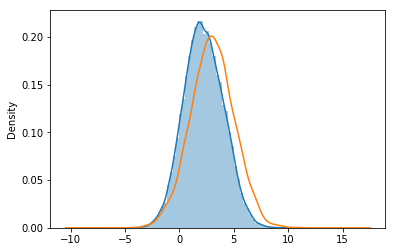

In [58]:
from scipy import stats 
from pandas import Series,DataFrame
import pymc as pm

# 目标分布N(3,4)
def stationary_distribution_propbility(x): 
    return stats.norm.pdf(x,loc=3,scale=2)

N = 5000
pi = Series(np.zeros(5000))
t = 0
while t<N-1:
    t = t+1
    q_mu = 1
    q_sigma = 3
    x = pm.Normal('Q',q_mu ,1./q_sigma**2 , size=1).value[0]
    u = pm.Uniform('u',lower=0,upper=1,size=1).value[0]
    a = min(1,stationary_distribution_propbility(x)/stationary_distribution_propbility(pi[t-1]))
    if (u<a):
        pi[t] = x
    else:
        t = t-1
        

# pi.plot.hist(bins=50,alpha=0.7,normed=True)
# 抽样得出的分布柱图和密度曲线
sns.distplot(pi,bins=50)
# 真实密度曲线 N(3,4)
Series(pm.Normal('true_density',3,1./4,size=5000).value).plot.density()

In [ ]:
1. 刘建平的MCMC算法实现了抽样出期望分布的样本集
2. 贝叶斯方法书中说MCMC反悔了后验分布的样本点, 和后验有什么关系
3. LDA的MCMC用于计算LDA文档生成概率, 这是怎么实现的